In [1]:
pip install pvlib

Note: you may need to restart the kernel to use updated packages.


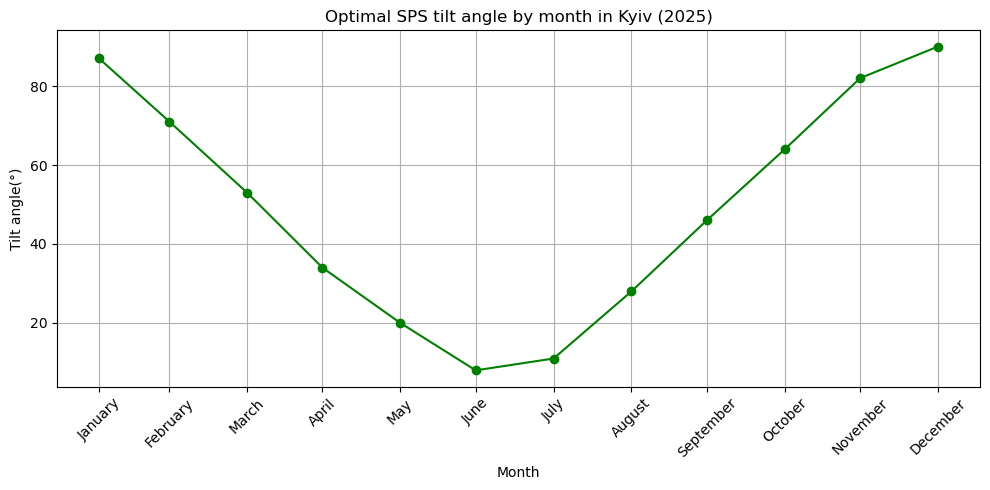

                           Best Tilt      Month
2025-01-31 00:00:00+02:00         87    January
2025-02-28 00:00:00+02:00         71   February
2025-03-31 00:00:00+03:00         53      March
2025-04-30 00:00:00+03:00         34      April
2025-05-31 00:00:00+03:00         20        May
2025-06-30 00:00:00+03:00          8       June
2025-07-31 00:00:00+03:00         11       July
2025-08-31 00:00:00+03:00         28     August
2025-09-30 00:00:00+03:00         46  September
2025-10-31 00:00:00+02:00         64    October
2025-11-30 00:00:00+02:00         82   November
2025-12-31 00:00:00+02:00         90   December
49.5


In [3]:
# Знаходження різних кутів нахилу панелей для різних регіонів України 
# (помісячно та оптимальний кут на рік – якщо панель стаціонарна)
# Київ

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pvlib.location import Location
import pvlib

# Час: щогодини 2025 рік
times = pd.date_range('2025-01-01', '2025-12-31 23:00', freq='1h', tz='Europe/Kyiv')

# Київ
location = Location(latitude=50.45, longitude=30.52, tz='Europe/Kyiv')
solar_position = location.get_solarposition(times)

# Кути нахилу (0–90° кожен 1 градус)
tilts = list(range(0, 91, 1))
results = {}

for tilt in tilts:
    aoi = pvlib.irradiance.aoi(
        surface_tilt=tilt,
        surface_azimuth=180,
        solar_zenith=solar_position['apparent_zenith'],
        solar_azimuth=solar_position['azimuth']
    )
    cos_aoi = np.cos(np.radians(aoi))
    cos_aoi[cos_aoi < 0] = 0
    results[f'tilt_{tilt}'] = cos_aoi

# Об'єднання в DataFrame
df = pd.DataFrame(results, index=times)

# Середнє значення по місяцях
monthly_avg = df.resample('ME').mean()

# Визначення найкращого кута для кожного місяця
monthly_best = monthly_avg.idxmax(axis=1).str.extract(r'(\d+)').astype(int)
# Створюємо стовпчик з назвою - найкращий кут:
monthly_best.columns = ['Best Tilt']
    
# Додаємо новий стовпець "Month" із назвами місяців текстом
monthly_best['Month'] = monthly_best.index.strftime('%B')

# Побудова графіка
plt.figure(figsize=(10, 5))
plt.plot(monthly_best.index, monthly_best['Best Tilt'], marker='o', color='green')
plt.title('Optimal SPS tilt angle by month in Kyiv (2025)')
plt.xlabel('Month')
plt.ylabel('Tilt angle(°)')
plt.grid(True)
plt.xticks(monthly_best.index, monthly_best['Month'], rotation=45)
plt.tight_layout()
plt.show()

# Друк таблиці
print(monthly_best)
print(monthly_best['Best Tilt'].mean())


                           Best Tilt      Month  Vertical (90°)  \
2025-01-31 00:00:00+02:00         87    January        0.352796   
2025-02-28 00:00:00+02:00         71   February        0.312797   
2025-03-31 00:00:00+03:00         53      March        0.253835   
2025-04-30 00:00:00+03:00         34      April        0.189275   
2025-05-31 00:00:00+03:00         20        May        0.137590   
2025-06-30 00:00:00+03:00          8       June        0.115520   
2025-07-31 00:00:00+03:00         11       July        0.126407   
2025-08-31 00:00:00+03:00         28     August        0.169303   
2025-09-30 00:00:00+03:00         46  September        0.230511   
2025-10-31 00:00:00+02:00         64    October        0.293312   
2025-11-30 00:00:00+02:00         82   November        0.342754   
2025-12-31 00:00:00+02:00         90   December        0.364864   

                           Best Efficiency  Efficiency (45°)  \
2025-01-31 00:00:00+02:00         0.353104          0.280135   


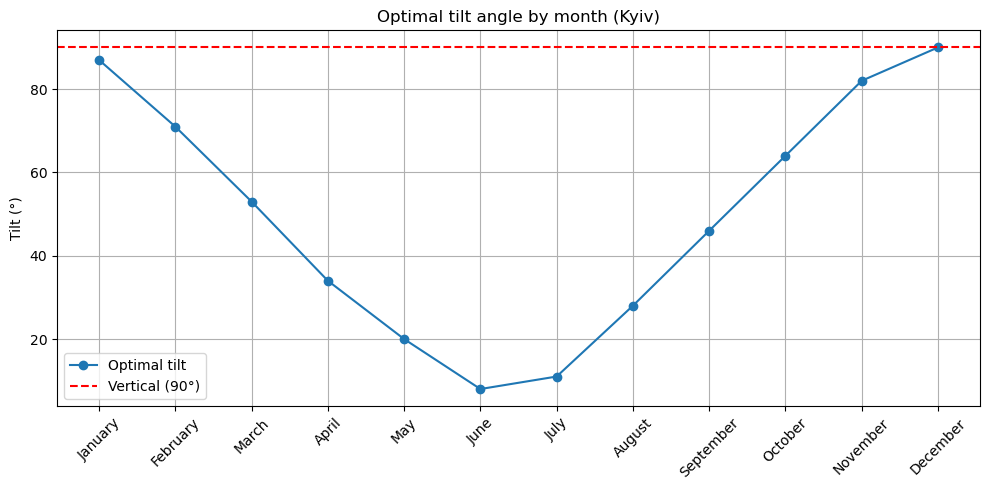

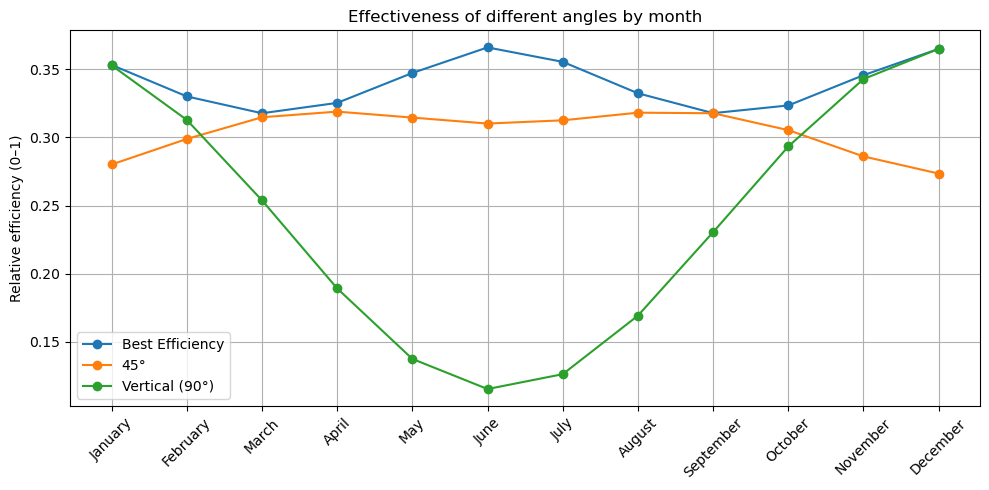

'monthly_efficiency_comparison.csv'

In [4]:
# Порівняння 3 варіантів - 90 / 45 / та теоретична макс.ефективність за будь-якого кута (динамічного)
# різниця ефективностей 90 та 45. Де 90 - ефективніша за 45 в 4 місяцях, а 5й - майже однаково.

import pandas as pd
import numpy as np
from pvlib.location import Location
import pvlib
import matplotlib.pyplot as plt

# 1. Створення діапазону часу для 2025 року
times = pd.date_range('2025-01-01', '2025-12-31 23:00', freq='1h', tz='Europe/Kyiv')
location = Location(latitude=50.45, longitude=30.52, tz='Europe/Kyiv')
solar_position = location.get_solarposition(times)

# 2. Кути нахилу: 0–90 з кроком 1°
tilts = list(range(0, 91))
results = {}

# 3. Розрахунок ефективності (cos(AOI)) для кожного кута
for tilt in tilts:
    aoi = pvlib.irradiance.aoi(
        surface_tilt=tilt,
        surface_azimuth=180,
        solar_zenith=solar_position['apparent_zenith'],
        solar_azimuth=solar_position['azimuth']
    )
    cos_aoi = np.cos(np.radians(aoi))
    cos_aoi[cos_aoi < 0] = 0
    results[f'tilt_{tilt}'] = cos_aoi

# 4. Побудова DataFrame і обчислення середньомісячних значень
df = pd.DataFrame(results, index=times)
monthly_avg = df.resample('ME').mean()

# 5. Формування підсумкової таблиці
best_tilts = monthly_avg.idxmax(axis=1).str.extract(r'(\d+)').astype(int)
best_tilts.columns = ['Best Tilt']
best_tilts['Month'] = monthly_avg.index.strftime('%B')
best_tilts['Vertical (90°)'] = monthly_avg['tilt_90'].values
best_tilts['Best Efficiency'] = [
    monthly_avg.loc[i, col] for i, col in zip(monthly_avg.index, monthly_avg.idxmax(axis=1))
]
best_tilts['Efficiency (45°)'] = monthly_avg['tilt_45'].values
best_tilts['Loss (%) vs Best'] = 100 * (1 - best_tilts['Vertical (90°)'] / best_tilts['Best Efficiency'])
best_tilts['Loss (%) vs 45°'] = 100 * (1 - best_tilts['Vertical (90°)'] / best_tilts['Efficiency (45°)'])

print(best_tilts)

# 6. Побудова графіка — оптимальний кут
plt.figure(figsize=(10, 5))
plt.plot(best_tilts['Month'], best_tilts['Best Tilt'], marker='o', label='Optimal tilt')
plt.axhline(90, linestyle='--', color='red', label='Vertical (90°)')
plt.title('Optimal tilt angle by month (Kyiv)')
plt.ylabel('Tilt (°)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Побудова графіка — ефективність
plt.figure(figsize=(10, 5))
plt.plot(best_tilts['Month'], best_tilts['Best Efficiency'], marker='o', label='Best Efficiency')
plt.plot(best_tilts['Month'], best_tilts['Efficiency (45°)'], marker='o', label='45°')
plt.plot(best_tilts['Month'], best_tilts['Vertical (90°)'], marker='o', label='Vertical (90°)')
plt.title('Effectiveness of different angles by month')
plt.ylabel('Relative efficiency (0–1)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




# 7. Збереження у CSV
csv_path = "monthly_efficiency_comparison.csv"
best_tilts.to_csv(csv_path, index=False)

csv_path


In [6]:
# Розрахунок оптимального кута для різних міст України

import pandas as pd
import numpy as np
from pvlib.location import Location
import pvlib

# Список обласних центрів України
cities = {
    'Kyiv': (50.45, 30.52),
    'Lviv': (49.84, 24.03),
    'Kharkiv': (49.99, 36.23),
    'Odesa': (46.48, 30.73),
    'Dnipro': (48.46, 35.04),
    'Zaporizhzhya': (47.84, 35.14),
    'Vinnytsya': (49.23, 28.48),
    'Khmelnytskyi': (49.42, 26.99),
    'Ternopil': (49.56, 25.59),
    'Ivano-Frankivsk': (48.92, 24.71),
    'Chernivtsi': (48.29, 25.94),
    'Zhytomyr': (50.25, 28.66),
    'Chernihiv': (51.5, 31.3),
    'Sumy': (50.92, 34.78),
    'Poltava': (49.59, 34.55),
    'Kropyvnytskyi': (48.51, 32.26),
    'Cherkasy': (49.44, 32.06),
    'Mykolaiv': (46.97, 31.99),
    'Kherson': (46.63, 32.6),
    'Lutsk': (50.75, 25.34),
    'Uzhgorod': (48.62, 22.3),
    'Rivne': (50.62, 26.25)
}

# Період для обчислень
times = pd.date_range('2025-01-01', '2025-12-31 23:00', freq='1h', tz='Europe/Kyiv')
tilts = list(range(0, 91, 1))
results_list = []

# Обчислення для кожного міста
for city, (lat, lon) in cities.items():
    location = Location(latitude=lat, longitude=lon, tz='Europe/Kyiv')
    solar_position = location.get_solarposition(times)
    
    tilt_efficiencies = {}
    for tilt in tilts:
        aoi = pvlib.irradiance.aoi(
            surface_tilt=tilt,
            surface_azimuth=180,
            solar_zenith=solar_position['apparent_zenith'],
            solar_azimuth=solar_position['azimuth']
        )
        cos_aoi = np.cos(np.radians(aoi))
        cos_aoi[cos_aoi < 0] = 0
        tilt_efficiencies[tilt] = cos_aoi

    df_city = pd.DataFrame(tilt_efficiencies, index=times)
    monthly_avg = df_city.resample('ME').mean()

    for month, row in monthly_avg.iterrows():
        best_tilt = row.idxmax()
        best_eff = row.max()
        fourty_five_eff = row[45]
        vert_eff = row[90]
        loss9045 = 100 * (1 - vert_eff / fourty_five_eff)
        loss90best = 100 * (1 - vert_eff / best_eff)
        results_list.append({
            'City': city,
            'Latitude': lat,
            'Longitude': lon,
            'Month': month.strftime('%B'),
            'Month_date': month,
            'Optimal tilt': best_tilt,
            'Efficiency (45°)': fourty_five_eff,
            'Efficiency (90°)': vert_eff,
            '90° SPS losses vs 45° SPS (%)': loss9045,
            '90° SPS losses vs dynamic SPS (%)': loss90best
        })

# Формування таблиць
df_cities_monthly = pd.DataFrame(results_list)
df_summary = df_cities_monthly.groupby('City').agg({
    'Latitude': 'first',
    'Longitude': 'first',
    'Optimal tilt': 'mean',
    '90° SPS losses vs 45° SPS (%)': 'mean',
    '90° SPS losses vs dynamic SPS (%)': 'mean'
}).rename(columns={
    'Optimal tilt': 'Average optimal tilt',
    '90° SPS losses vs 45° SPS (%)': '90° SPS average losses vs 45° SPS (%)',
    '90° SPS losses vs dynamic SPS (%)': '90° SPS average losses vs dynamic SPS (%)'
}).reset_index()

print(df_summary)
print(df_cities_monthly)

               City  Latitude  Longitude  Average optimal tilt  \
0          Cherkasy     49.44      32.06             48.583333   
1         Chernihiv     51.50      31.30             50.500000   
2        Chernivtsi     48.29      25.94             47.416667   
3            Dnipro     48.46      35.04             47.666667   
4   Ivano-Frankivsk     48.92      24.71             47.833333   
5           Kharkiv     49.99      36.23             48.916667   
6           Kherson     46.63      32.60             45.916667   
7      Khmelnytskyi     49.42      26.99             48.500000   
8     Kropyvnytskyi     48.51      32.26             47.666667   
9              Kyiv     50.45      30.52             49.500000   
10            Lutsk     50.75      25.34             49.916667   
11             Lviv     49.84      24.03             48.750000   
12         Mykolaiv     46.97      31.99             46.416667   
13            Odesa     46.48      30.73             45.583333   
14        

In [7]:
# Експорт файлів для Табло:
df_cities_monthly.to_csv("solar_tilt_ukraine_monthly.csv", index=False)
df_summary.to_csv("solar_tilt_ukraine_summary.csv", index=False)

In [8]:
# Тут створюємо карту в Пайтоні для міст України

!pip install folium
import folium
from folium.plugins import MarkerCluster
import pandas as pd

# df_summary — таблиця зі стовпцями:
    # 'City', 'Latitude', 'Longitude',
    # 'Average optimal tilt', '90° SPS average losses vs 45° SPS (%)', '90° SPS average losses vs dynamic SPS (%)'

m = folium.Map(location=[49.0, 31.0], zoom_start=6)
marker_cluster = MarkerCluster().add_to(m)

for _, row in df_summary.iterrows():
    tooltip = f"{row['City']}<br>Optimal tilt: {row['Average optimal tilt']:.1f}°<br>90° SPS average losses vs 45° SPS (%): {row['90° SPS average losses vs 45° SPS (%)']:.1f}%<br>90° SPS average losses vs dynamic SPS (%): {row['90° SPS average losses vs dynamic SPS (%)']:.1f}%"
    color = 'green' if row['90° SPS average losses vs 45° SPS (%)'] < 10 else 'orange' if row['90° SPS average losses vs 45° SPS (%)'] < 25 else 'red'

    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=8,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=folium.Popup(tooltip, max_width=250),
    ).add_to(marker_cluster)

# Зберегти карту
m.save("solar_tilt_ukraine_map.html")